# Mean Atmospheric Temperature

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import os.path as op
import sys
import folium

import numpy as np
import pandas as pd

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs, fontsize
from ind_setup.colors import get_df_col

sys.path.append("../../../functions")
from data_downloaders import GHCN

## Define location and variables of interest

In [3]:
country = 'Palau'
vars_interest = ['TMIN', 'TMAX']

## Get Data

In [4]:
update_data = False
path_data = "../../../data"

## Using Koror Station

Analysis of how much the maximum and minimum temperatures over time are changing. <br>
The analysis of the difference between these 2 variables will allow us to know how the daily variability is being modified

In [5]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [6]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['diff'] = st_data['TMAX'] - st_data['TMIN']
    st_data['TMEAN'] = (st_data['TMAX'] + st_data['TMIN'])/2
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))

In [7]:
st_data = st_data.resample('Y').mean()

### Mean temperature

In [8]:
dict_plot = [{'data' : st_data, 'var' : 'TMEAN', 'ax' : 1, 'label' : 'TMEAN'},
        ]

In [9]:
dict_plot = [{'data' : st_data, 'var' : 'TMEAN', 'ax' : 1, 'label' : 'TMEAN'}]
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12))


In [10]:
st_data['TMEAN_ref'] = st_data['TMEAN'] - st_data.loc['1961':'1990'].TMEAN.mean()

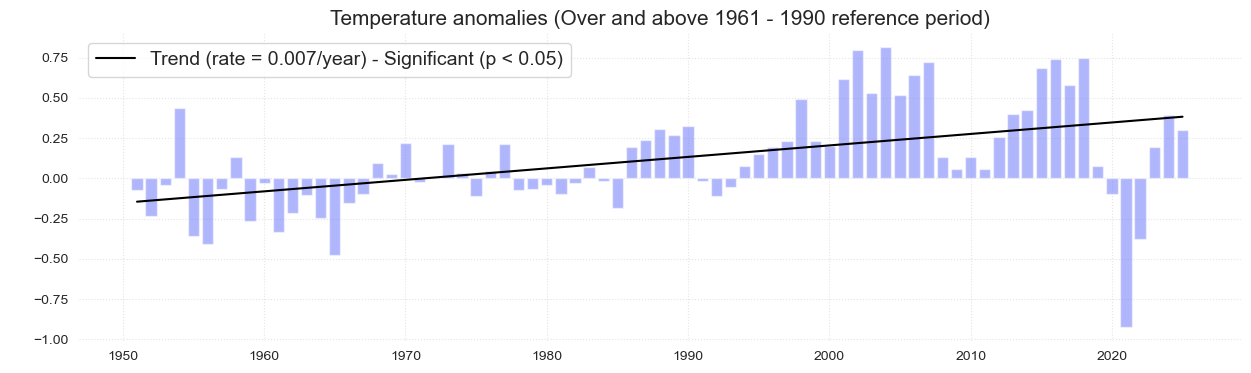

In [11]:
import matplotlib.pyplot as plt
plot_bar_probs(x = st_data.index.year, y = st_data.TMEAN_ref, trendline = True, figsize = [15, 4])
plt.title('Temperature anomalies (Over and above 1961 - 1990 reference period)', fontsize = 15);

In [12]:
nevents = 10
top_10 = st_data.sort_values(by='TMEAN_ref', ascending=False).head(nevents)

In [13]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

def get_data_metrics(st_data, var):
    mean = np.nanmean(st_data[var])
    std = np.nanstd(st_data[var])
    max_val = np.nanmax(st_data[var])
    min_val = np.nanmin(st_data[var])
    median = np.nanmedian(st_data[var])
    range_val = max_val - min_val
    trend = np.polyfit(st_data.index.year, st_data[var], 1)[0]
    
    # Extreme events
    threshold = mean + 2 * std
    extreme_days = len(st_data[var] > threshold)
    
    # Percentiles
    p10 = np.nanpercentile(st_data[var], 10)
    p90 = np.nanpercentile(st_data[var], 90)
    
    
    # Compile metrics
    df = pd.DataFrame({
        'Mean': mean,
        'Median': median,
        'Standard deviation': std,
        'Maximum': max_val,
        'Minimum': min_val,
        'Range': range_val,
        '10th Percentile': p10,
        '90th Percentile': p90,
        'Trend': trend,
        'Extreme Days (>2σ)': extreme_days,
    }, index=[var])
    
    return np.round(df, 3)


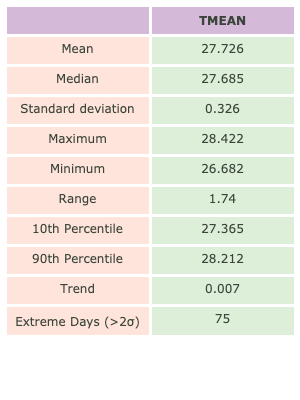

In [14]:
from ind_setup.tables import plot_df_table

var = 'TMEAN'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

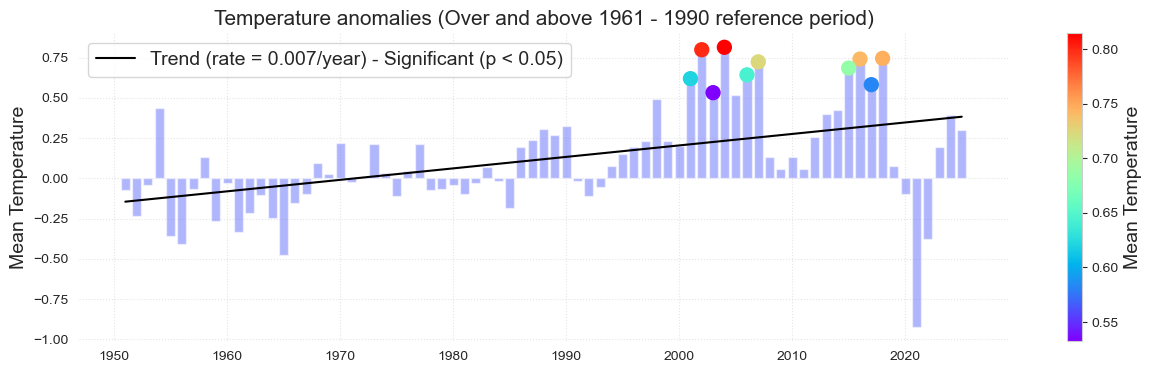

In [15]:
import matplotlib.pyplot as plt
ax = plot_bar_probs(x = st_data.index.year, y = st_data.TMEAN_ref, trendline = True,
                    y_label = 'Mean Temperature', figsize = [15, 4])

im = ax.scatter(top_10.index.year, top_10.TMEAN_ref, 
           c=top_10.TMEAN_ref.values, s=100,
            cmap = 'rainbow', label='Top 10 warmest years')
plt.title('Temperature anomalies (Over and above 1961 - 1990 reference period)', fontsize = 15)
plt.colorbar(im).set_label('Mean Temperature', fontsize = fontsize)

### Minimum temperature

In [16]:
dict_plot = [{'data' : st_data, 'var' : 'TMIN', 'ax' : 1, 'label' : 'TMIN'},
        # {'data' : st_data, 'var' : 'TMAX', 'ax' : 1, 'label' : 'TMAX'},
        # {'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}
        ]

In [17]:
dict_plot = [{'data' : st_data, 'var' : 'TMIN', 'ax' : 1, 'label' : 'TMIN'}]
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12))


### Maximum temperature

In [18]:
dict_plot = [{'data' : st_data, 'var' : 'TMAX', 'ax' : 1, 'label' : 'TMAX'}]
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12))


In [19]:
dict_plot = [{'data' : st_data, 'var' : 'TMIN', 'ax' : 1, 'label' : 'TMIN'},
        {'data' : st_data, 'var' : 'TMAX', 'ax' : 2, 'label' : 'TMAX'},
        # {'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}
        ]

In [20]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (24, 11))


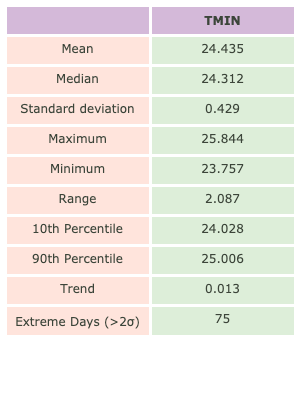

In [21]:
from ind_setup.tables import plot_df_table

var = 'TMIN'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

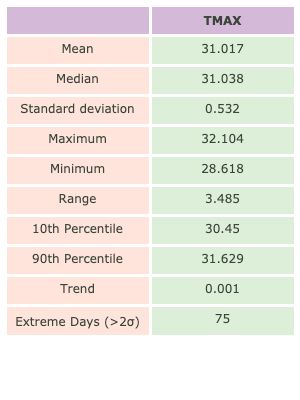

In [22]:
from ind_setup.tables import plot_df_table

var = 'TMAX'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

### Difference temperature

In [23]:
dict_plot = [{'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}]
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12))


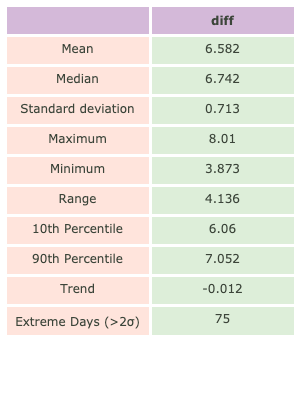

In [24]:
from ind_setup.tables import plot_df_table

var = 'diff'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))